Kvasir dataset split into neg/pos and trained using Resnet50 without augmentation.  
- Class weighting  
- Resampling  
- Initial Bias-estimation
- Decreasing learning rate

### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

# Some stuff to make utils-function work
import sys
sys.path.append('/home/henrik/master_thesis/code/utils')
from data_prep import create_dataset, print_class_info, show_image
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Some parameters

In [3]:
data_dir = pathlib.Path('/mnt/sdb/kvasir-dataset-v2/')

config = {
    "data_dir": data_dir,
    "cache_dir": "./cache",
    "model": 'resnet50',
    "ds_info": 'binary',
    "resample": False,
    "neg_class": ['normal-cecum'],
    "num_epochs": 100,
    "batch_size": 128,
    "img_shape": (32, 32, 3),
    "outcast": None,
    "optimizer": 'Adam',
    "final_activation": 'sigmoid',
    "learning_rate": 0.001,
    "early_stopping_patience": 10,
    "decay_rate": 0.4,              # higher number gives steeper dropoff
    "verbosity": 1
    }

model_name = '{}x{}x{}_{}_{}'.format(config["num_epochs"], config["batch_size"], 
                                     config["img_shape"][1], config["ds_info"], config["model"])

learning_rate = config["learning_rate"]
fine_tune_at = 130
fine_tune_epochs = 150
early_stopping_patience = config["early_stopping_patience"]

Create training, testing and validation dataset from utils/data_prep.py

In [4]:
train_ds, test_ds, val_ds, params = create_dataset(config)

train_steps = params["train_size"] // config["batch_size"]
test_steps = params["test_size"] // config["batch_size"]
val_steps = params["val_size"] // config["batch_size"]

neg = params["neg_count"]
pos = params["pos_count"]
total = params["ds_size"]

Negative class names:
        - normal-cecum
Positive class names:
        - esophagitis
        - normal-pylorus
        - ulcerative-colitis
        - normal-z-line
        - polyps
        - dyed-resection-margins
        - dyed-lifted-polyps

Negative samples:  1000 | 12.50%
Positive samples:  7000 | 87.50%

Total number of images: 8000
Dataset.list_files:  /mnt/sdb/kvasir-dataset-v2/*/*.*g 

[1 1 1 1 1 1 1 1 1 1]
[1 1 0 0 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 0 1 1 0 0 1 1]
[0 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[0 1 1 1 0 1 0 1 0 1]
[1 1 1 1 1 0 1 1 1 1]
[1 1 1 1 1 1 0 1 0 1]
[1 1 1 0 1 1 0 1 1 1]

Full dataset sample size:         8000
Train dataset sample size:        5600
Test dataset sample size:         1200
Validation dataset sample size:   1200


# Training

### Resnet50 transfer learning
see https://adventuresinmachinelearning.com/transfer-learning-tensorflow-2/  
imbalanced-data: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [5]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler

import datetime

In [6]:
metrics = [
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'), 
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
]

In [7]:
res_net = tf.keras.applications.ResNet50(
                weights='imagenet', 
                include_top=False, 
                input_shape=config["img_shape"])

res_net.trainable = True

In [8]:
def make_model(output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    global_average_layer = GlobalAveragePooling2D()
    output_layer = Dense(1, activation='sigmoid',
                         bias_initializer=output_bias)

    resnet50_model = tf.keras.Sequential([
            res_net,
            global_average_layer,
            output_layer])
    
    if config['optimizer'] == 'Adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif config['optimizer'] == 'SGD':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    resnet50_model.compile(
            optimizer=opt,
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=metrics)
    
    return resnet50_model

### Callbacks

In [9]:
initial_learning_rate = learning_rate
decay_steps = train_steps
batch_size = config['batch_size']
decay_rate = config['decay_rate']

def schedule(epoch):
    # calculate new learning rate
    learning_rate = initial_learning_rate / (1 + decay_rate * (epoch*batch_size) / decay_steps)
    
    # update tensorboard
    tf.summary.scalar(name='learning_rate', data=learning_rate, step=epoch)
    return learning_rate

log_dir="./logs/{}/".format(config["model"]) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
file_writer.set_as_default()

lr_schedule_cb = LearningRateScheduler(schedule, verbose=1)
earlystopp_cb = EarlyStopping(monitor='val_loss',verbose=1, patience=early_stopping_patience, restore_best_weights=True)
checkpoint_cb = ModelCheckpoint(filepath='./models/best_cp-{epoch:03d}.hdf', monitor='val_loss', save_best_only=True, mode='auto')
tensorboard_cb = TensorBoard(log_dir=log_dir, update_freq='batch')

callbacks = [tensorboard_cb, earlystopp_cb, lr_schedule_cb]

# Write config dictionary to text file
f = open(log_dir+"/config.txt","w")
f.write( str(config) )
f.close()

## Set correct initial bias


In [10]:
bias_model = make_model()

# Test run the model and show 10 first predictions of one epoch
bias_model.predict(train_ds.take(1))[:10]

array([[0.01651019],
       [0.02074003],
       [0.01782346],
       [0.01698971],
       [0.01889473],
       [0.01868799],
       [0.01675355],
       [0.01239654],
       [0.01565892],
       [0.01421055]], dtype=float32)

In [11]:
results = bias_model.evaluate(train_ds, verbose=0, steps=train_steps)
print("Loss: {:0.4f}".format(results[0]))

Loss: 3.6329


In [12]:
initial_bias = np.log([pos/neg])
print ("The initial bias should then be: {:.4f}".format(initial_bias[0]))

The initial bias should then be: 1.9459


In [13]:
new_bias_model = make_model(output_bias = initial_bias)
new_bias_model.predict(train_ds, verbose=0, steps=train_steps)

print ("Initial guess should be around:", pos/total)
new_bias_model.predict(train_ds.take(1))[:10]

Initial guess should be around: 0.875


array([[0.43302327],
       [0.40926737],
       [0.45541528],
       [0.45709002],
       [0.40368748],
       [0.4123215 ],
       [0.4513257 ],
       [0.4194557 ],
       [0.5030199 ],
       [0.3955887 ]], dtype=float32)

In [14]:
results = new_bias_model.evaluate(train_ds, verbose=0, steps=train_steps)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.7990


In [15]:
initial_weights = os.path.join(log_dir,'initial_weights')
new_bias_model.save_weights(initial_weights)

#### Confirm that the bias fix helps

In [16]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_loss(history, label, n):
    # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
    plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()

## Baseline

In [17]:
baseline_model = make_model()
baseline_model.load_weights(initial_weights)

baseline_history = baseline_model.fit(
    train_ds,
    steps_per_epoch = train_steps,
    epochs = config["num_epochs"],
    validation_data = test_ds,
    validation_steps = test_steps,
    validation_freq = 1,
    callbacks = callbacks
)

Train for 43 steps, validate for 9 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/100
43/43 [==============================] - 42s 982ms/step - loss: 0.1488 - tp: 4709.0000 - fp: 174.0000 - tn: 508.0000 - fn: 113.0000 - accuracy: 0.9479 - precision: 0.9644 - recall: 0.9766 - auc: 0.9691 - val_loss: 18.9973 - val_tp: 1006.0000 - val_fp: 146.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.8733 - val_precision: 0.8733 - val_recall: 1.0000 - val_auc: 0.5000

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0004564755838641189.
Epoch 2/100
43/43 [==============================] - 3s 61ms/step - loss: 0.0652 - tp: 4765.0000 - fp: 81.0000 - tn: 595.0000 - fn: 63.0000 - accuracy: 0.9738 - precision: 0.9833 - recall: 0.9870 - auc: 0.9943 - val_loss: 0.9933 - val_tp: 1004.0000 - val_fp: 148.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.8715 - val_precision: 0.8715 - val_recall: 1.0000 - val_auc: 0.5000

Epoch 0

`Keras`
Save/load the model

In [17]:
# cnn_model.save('models/{}.h5'.format(model_name))
# cnn_model = tf.keras.models.load_model('models/{}.h5'.format(model_name))

#### Validate the results

In [18]:
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

Some functions

In [19]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    plt.figure(figsize=(12, 10))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

In [20]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    
    metrics_list = np.asarray([['tn', 'fp'], ['fn', 'tp']])
    labels = (np.asarray(["{0}\n{1:.0f}".format(metrics_list,cm) for metrics_list, cm in zip(metrics_list.flatten(), cm.flatten())])).reshape(2,2)
    
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=labels, fmt="", robust=True, annot_kws={'size':16})
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    plt.ylim(2,0)

    print('Legitimate Lesions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Lesions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Lesions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Lesions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Lesions: ', np.sum(cm[1]))
    print()

In [21]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [22]:
def numpify(dataset, model, samples=4000):
    ds_eval = dataset.unbatch().take(samples)
    labels = []
    images = []
    for img, lab in ds_eval:
        labels.append(lab.numpy())
        images.append(img.numpy())

    pred = model.predict(np.expand_dims(images, axis=0)[-1])
    
    return (labels, pred)

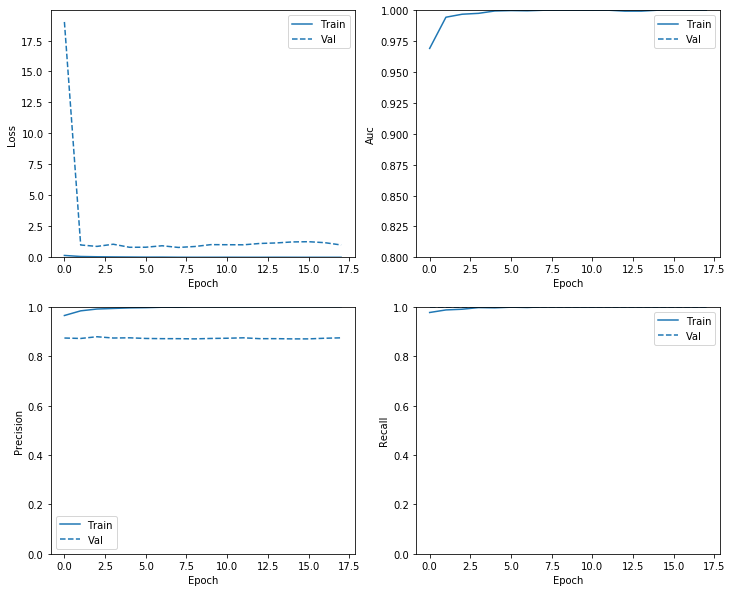

In [23]:
plot_metrics(baseline_history)
plt.savefig(log_dir+"/baseline_metrics_plot")

In [24]:
baseline_results = baseline_model.evaluate(val_ds, verbose=2, steps=val_steps)
print()

f = open(log_dir+"/baseline_val_results.txt","w")
for name, value in zip(baseline_model.metrics_names, baseline_results):
    line = "{} : {}\n".format(name, value)
    print(line, end='')
    f.write(line)
f.close()
print()

9/9 - 30s - loss: 0.7204 - tp: 1017.0000 - fp: 135.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.8828 - precision: 0.8828 - recall: 1.0000 - auc: 0.5000

loss : 0.7203929490513272
tp : 1017.0
fp : 135.0
tn : 0.0
fn : 0.0
accuracy : 0.8828125
precision : 0.8828125
recall : 1.0
auc : 0.5



In [25]:
train_labels_baseline, train_predictions_baseline = numpify(train_ds, baseline_model, samples=5000)
val_labels_baseline, val_predictions_baseline = numpify(val_ds, baseline_model, samples=5000)

Legitimate Lesions Detected (True Negatives):  0
Legitimate Lesions Incorrectly Detected (False Positives):  618
Fraudulent Lesions Missed (False Negatives):  0
Fraudulent Lesions Detected (True Positives):  4382
Total Fraudulent Lesions:  4382



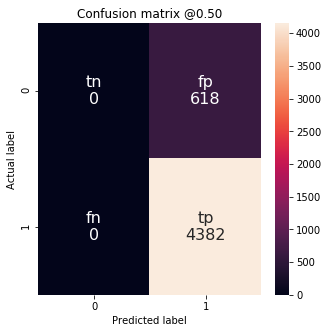

In [26]:
plot_cm(train_labels_baseline, train_predictions_baseline)
plt.savefig(log_dir+"/baseline_cm_plot")

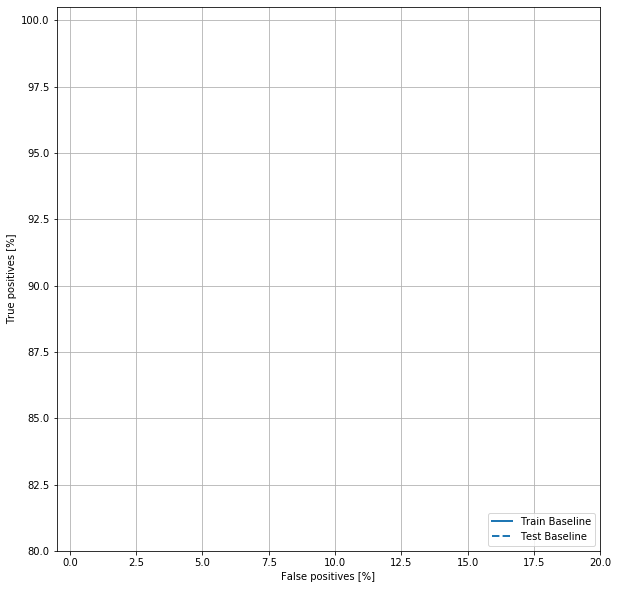

In [27]:
plt.figure(figsize=(10,10))

plot_roc("Train Baseline", train_labels_baseline, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", val_labels_baseline, val_predictions_baseline, color=colors[0], linestyle='--')

plt.legend(loc='lower right');
plt.savefig(log_dir+"/baseline_roc_plot")

### Calculate class weights
See https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights

In [28]:
weight_for_0 = (1/neg)*(total)/2.0
weight_for_1 = (1/pos)*(total)/2.0

class_weight = {0: weight_for_0,
                1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 4.00
Weight for class 1: 0.57


In [29]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_ds,
    steps_per_epoch = train_steps,
    epochs = config["num_epochs"],
    validation_data = test_ds,
    validation_steps = test_steps,
    validation_freq = 1,
    class_weight = class_weight,
    callbacks = callbacks
)

Train for 43 steps, validate for 9 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/100
43/43 [==============================] - 12s 284ms/step - loss: 0.1535 - tp: 4710.0000 - fp: 196.0000 - tn: 488.0000 - fn: 110.0000 - accuracy: 0.9444 - precision: 0.9600 - recall: 0.9772 - auc: 0.9692 - val_loss: 574.4984 - val_tp: 1007.0000 - val_fp: 145.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.8741 - val_precision: 0.8741 - val_recall: 1.0000 - val_auc: 0.5000

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0004564755838641189.
Epoch 2/100
43/43 [==============================] - 3s 61ms/step - loss: 0.0766 - tp: 4757.0000 - fp: 84.0000 - tn: 591.0000 - fn: 72.0000 - accuracy: 0.9717 - precision: 0.9826 - recall: 0.9851 - auc: 0.9917 - val_loss: 424.5178 - val_tp: 1003.0000 - val_fp: 149.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.8707 - val_precision: 0.8707 - val_recall: 1.0000 - val_auc: 0.5000

Epoc

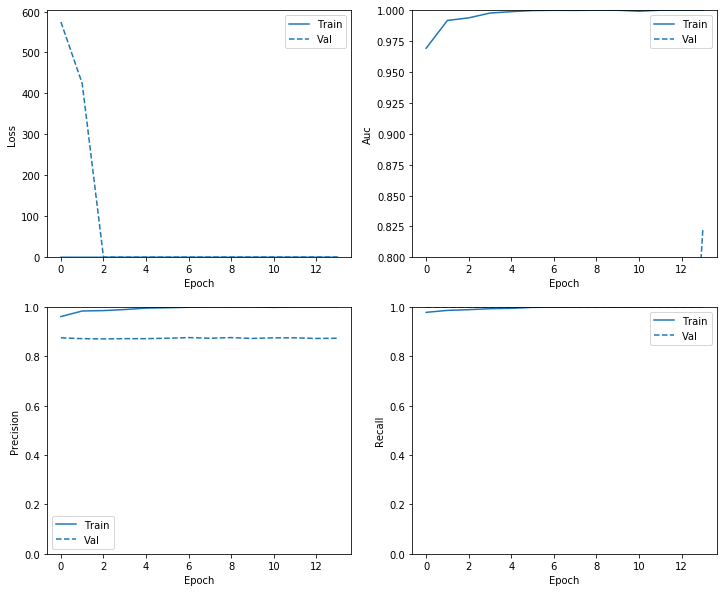

In [30]:
plot_metrics(weighted_history)
plt.savefig(log_dir+"/weighted_metrics_plot")

In [31]:
weighted_results = weighted_model.evaluate(val_ds, verbose=2, steps=val_steps)
print()

f = open(log_dir+"/weighted_val_results.txt","w")
for name, value in zip(baseline_model.metrics_names, weighted_results):
    line = "{} : {}\n".format(name, value)
    print(line, end='')
    f.write(line)
f.close()
print()

9/9 - 0s - loss: 0.4255 - tp: 1015.0000 - fp: 137.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.8811 - precision: 0.8811 - recall: 1.0000 - auc: 0.6456

loss : 0.42547763387362164
tp : 1015.0
fp : 137.0
tn : 0.0
fn : 0.0
accuracy : 0.8810763955116272
precision : 0.8810763955116272
recall : 1.0
auc : 0.6456006169319153



In [32]:
train_labels_weighted, train_predictions_weighted = numpify(train_ds, weighted_model, samples=5000)
val_labels_weighted, val_predictions_weighted = numpify(val_ds, weighted_model, samples=5000)

Legitimate Lesions Detected (True Negatives):  0
Legitimate Lesions Incorrectly Detected (False Positives):  624
Fraudulent Lesions Missed (False Negatives):  0
Fraudulent Lesions Detected (True Positives):  4376
Total Fraudulent Lesions:  4376



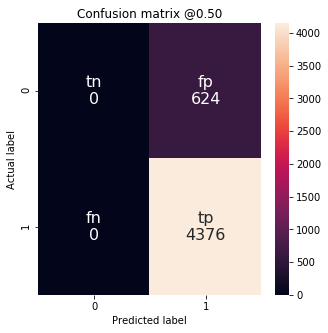

In [33]:
plot_cm(train_labels_weighted, train_predictions_weighted)
plt.savefig(log_dir+"/weighted_cm_plot")

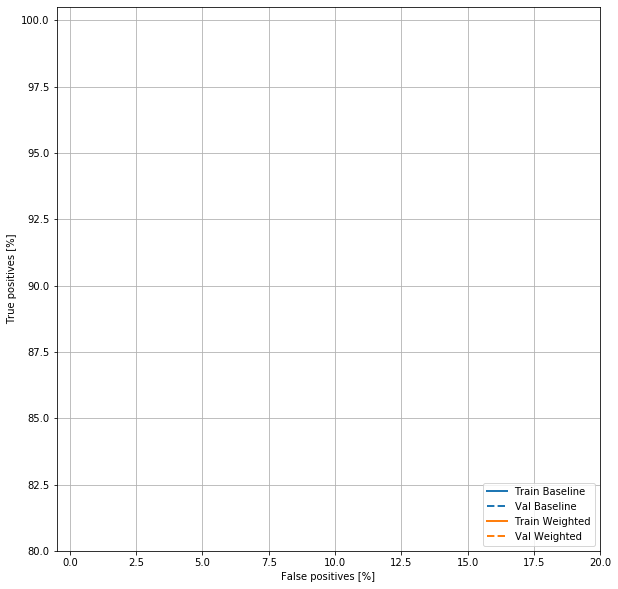

In [34]:
plt.figure(figsize=(10,10))

plot_roc("Train Baseline", train_labels_baseline, train_predictions_baseline, color=colors[0])
plot_roc("Val Baseline", val_labels_baseline, val_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels_weighted, train_predictions_weighted, color=colors[1])
plot_roc("Val Weighted", val_labels_weighted, val_predictions_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right');
plt.savefig(log_dir+"/weighted_roc_plot")

## Oversampling the minority class

In [35]:
# Remove the cache
!rm -rf ./cache/*

# Set dataset resample to true to make 5050 distribution of samples
config["resample"] = True

Create training, testing and validation dataset from utils/data_prep.py

In [36]:
train_ds_resampled, test_ds_resampled, val_ds_resampled, params = create_dataset(config)

Negative class names:
        - normal-cecum
Positive class names:
        - esophagitis
        - normal-pylorus
        - ulcerative-colitis
        - normal-z-line
        - polyps
        - dyed-resection-margins
        - dyed-lifted-polyps

Negative samples:  1000 | 12.50%
Positive samples:  7000 | 87.50%

Total number of images: 8000
Dataset.list_files:  /mnt/sdb/kvasir-dataset-v2/*/*.*g 

[1 1 1 0 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 0 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 0 1 1]
[1 0 1 1 1 1 1 1 1 1]
[1 0 1 1 0 1 1 1 1 0]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 0]
[1 0 1 1 1 1 1 1 1 1]

Resamplng the dataset..

Fractions:  [0.125 0.875]
Counts:  [1000. 7000.]

[1 0 0 1 1 1 0 0 0 1]
[0 1 1 0 0 0 1 0 1 1]
[0 1 0 1 1 0 0 1 0 0]
[0 1 0 0 0 1 1 0 0 1]
[0 0 0 1 1 0 0 0 1 1]
[1 1 0 1 1 0 1 0 1 0]
[1 0 0 0 1 1 1 0 0 1]
[0 1 0 0 0 1 0 1 1 1]
[0 1 1 1 1 1 1 1 0 0]
[1 1 1 1 0 1 0 0 0 0]


In [37]:
# Check the mean value is close to 0.5
for img, label in train_ds_resampled.take(3):
    print(label.numpy().mean())

0.5625
0.6015625
0.5


In [38]:
resampled_steps_per_epoch = np.ceil(2.0*neg/config["batch_size"])
print (resampled_steps_per_epoch)

16.0


In [51]:
resampled_steps_per_epoch = 200

In [52]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

resampled_history = resampled_model.fit(
    train_ds_resampled,
    steps_per_epoch = resampled_steps_per_epoch,
    epochs = config["num_epochs"],
    validation_data = test_ds_resampled,
    validation_steps = resampled_steps_per_epoch,
    validation_freq = 1,
    callbacks = callbacks
)

Train for 200 steps, validate for 200 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/100
200/200 [==============================] - 24s 119ms/step - loss: 0.1055 - tp: 12461.0000 - fp: 554.0000 - tn: 12193.0000 - fn: 392.0000 - accuracy: 0.9630 - precision: 0.9574 - recall: 0.9695 - auc: 0.9925 - val_loss: 1.0353 - val_tp: 12589.0000 - val_fp: 13011.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4918 - val_precision: 0.4918 - val_recall: 1.0000 - val_auc: 0.7215

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0004564755838641189.
Epoch 2/100
200/200 [==============================] - 14s 72ms/step - loss: 0.0074 - tp: 12866.0000 - fp: 22.0000 - tn: 12669.0000 - fn: 43.0000 - accuracy: 0.9975 - precision: 0.9983 - recall: 0.9967 - auc: 0.9998 - val_loss: 1.5120 - val_tp: 12572.0000 - val_fp: 13028.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4911 - val_precision: 0.4911 - val_recall: 1.0000 - val_a

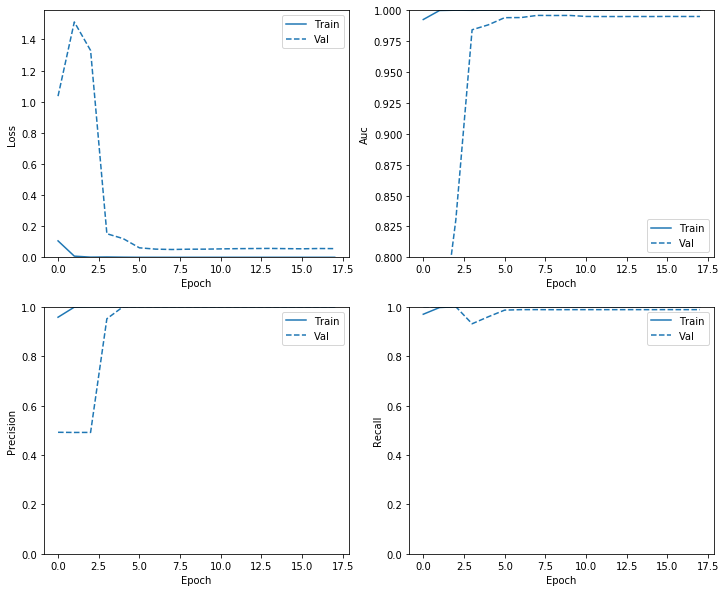

In [53]:
plot_metrics(resampled_history)
plt.savefig(log_dir+"/resampled_metrics_plot")

In [54]:
resampled_results = resampled_model.evaluate(val_ds_resampled, verbose=2, steps=val_steps)
print()

f = open(log_dir+"/resampled_val_results.txt","w")
for name, value in zip(resampled_model.metrics_names, resampled_results):
    line = "{} : {}\n".format(name, value)
    print(line, end='')
    f.write(line)
f.close()
print()

9/9 - 0s - loss: 0.0813 - tp: 992.0000 - fp: 0.0000e+00 - tn: 148.0000 - fn: 12.0000 - accuracy: 0.9896 - precision: 1.0000 - recall: 0.9880 - auc: 0.9960

loss : 0.08132847123488318
tp : 992.0
fp : 0.0
tn : 148.0
fn : 12.0
accuracy : 0.9895833134651184
precision : 1.0
recall : 0.9880478382110596
auc : 0.9960159063339233



In [61]:
train_labels_resampled, train_predictions_resampled = numpify(train_ds_resampled, resampled_model, samples=5000)
val_labels_resampled, val_predictions_resampled = numpify(val_ds_resampled, resampled_model, samples=5000)

Legitimate Lesions Detected (True Negatives):  655
Legitimate Lesions Incorrectly Detected (False Positives):  0
Fraudulent Lesions Missed (False Negatives):  54
Fraudulent Lesions Detected (True Positives):  4291
Total Fraudulent Lesions:  4345



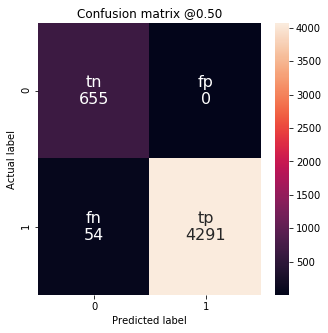

In [62]:
plot_cm(val_labels_resampled, val_predictions_resampled)
plt.savefig(log_dir+"/resampled_cm_plot")

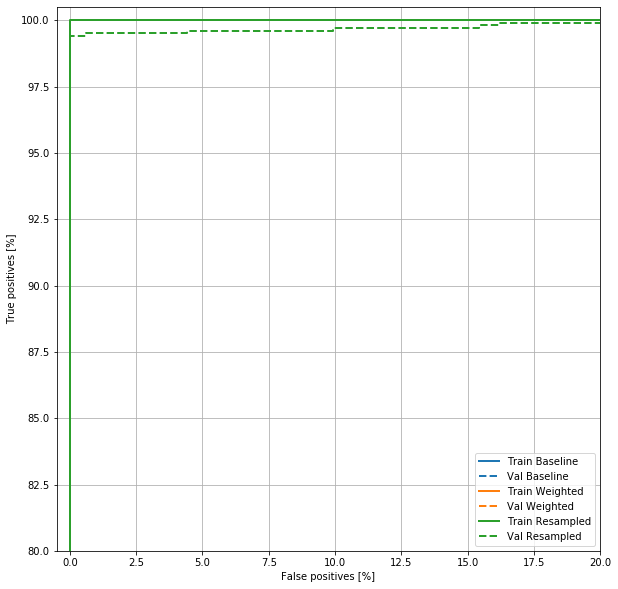

In [63]:
plt.figure(figsize=(10,10))

plot_roc("Train Baseline", train_labels_baseline, train_predictions_baseline, color=colors[0])
plot_roc("Val Baseline", val_labels_baseline, val_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels_weighted, train_predictions_weighted, color=colors[1])
plot_roc("Val Weighted", val_labels_weighted, val_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels_resampled, train_predictions_resampled, color=colors[2])
plot_roc("Val Resampled", val_labels_resampled, val_predictions_resampled, color=colors[2], linestyle='--')

plt.legend(loc='lower right');
plt.savefig(log_dir+"/resampled_roc_plot")

`Tensorboard`

## Predict new samples

In [58]:
# Fetch one batch
images, labels = next(iter(val_ds_resampled))

# Convert from tensor to numpy array
images = images.numpy()
labels = labels.numpy()

1.0000 | 1.0
Image 32 of 128


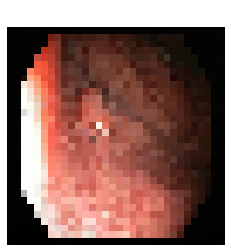

In [59]:
# Get a random image and label
rand = np.random.randint(0, config["batch_size"])
image = images[rand]
label = labels[rand]

# Predict one image
predictions = resampled_model.predict(np.expand_dims(image, axis=0))[0]
pred = predictions[0]
print("{:0.4f} | {}".format(pred, np.round(pred)))

prediction = ('Boat') if np.round(pred)==0 else ('Not boat')

print ("Image {} of {}".format(rand, config["batch_size"]))

plt.figure(frameon=False, facecolor='white');
plt.title(prediction, fontdict={'color':'white','size':20})
plt.imshow(image)
plt.axis('off');

In [60]:
# Predict one batch
predictions = resampled_model.predict(images)

print ('{:3}  {:5}  {:3}'.format('idx', 'label', 'pred'))
print ('---  -----  ----')

for i, prediction in enumerate(predictions.flat):
    print ('\n{:3}  {:.3f}  {:.3f}'.format(i, labels[i], prediction), end='')
    if (int(labels[i]) != int(np.round(prediction))): print (" -Wrong", end='')

idx  label  pred
---  -----  ----

  0  1.000  1.000
  1  0.000  0.000
  2  0.000  0.000
  3  1.000  1.000
  4  0.000  0.000
  5  0.000  0.000
  6  1.000  1.000
  7  1.000  1.000
  8  1.000  1.000
  9  1.000  1.000
 10  1.000  1.000
 11  1.000  1.000
 12  1.000  1.000
 13  0.000  0.000
 14  1.000  1.000
 15  1.000  1.000
 16  1.000  1.000
 17  1.000  1.000
 18  1.000  1.000
 19  0.000  0.000
 20  1.000  1.000
 21  1.000  1.000
 22  1.000  1.000
 23  0.000  0.000
 24  1.000  1.000
 25  1.000  1.000
 26  1.000  1.000
 27  1.000  1.000
 28  1.000  1.000
 29  1.000  1.000
 30  1.000  1.000
 31  1.000  1.000
 32  1.000  1.000
 33  1.000  1.000
 34  1.000  1.000
 35  1.000  0.994
 36  1.000  1.000
 37  1.000  1.000
 38  1.000  1.000
 39  1.000  1.000
 40  1.000  1.000
 41  1.000  1.000
 42  0.000  0.000
 43  1.000  1.000
 44  1.000  1.000
 45  1.000  1.000
 46  1.000  1.000
 47  1.000  1.000
 48  1.000  1.000
 49  0.000  0.000
 50  0.000  0.000
 51  1.000  1.000
 52  0.000  0.000
 53  1.000 